In [37]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [39]:
img_size = 32
img_channels = 1
n_classes = 10

batch_size = 128
n_epochs = 1000
learning_rate = 3e-4

T = 1000

In [40]:
mean, std = torch.tensor([0.1309,]), torch.tensor([0.2821,])   # MNIST
#mean, std = torch.tensor([0.4914, 0.4822, 0.4465]), torch.tensor([0.2023, 0.1994, 0.2010])   # CIFAR10
#mean, std = torch.tensor([0.5061, 0.4254, 0.3828]), torch.tensor([0.3076, 0.2872, 0.2866])    # CelebA

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    #transforms.RandomHorizontalFlip(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

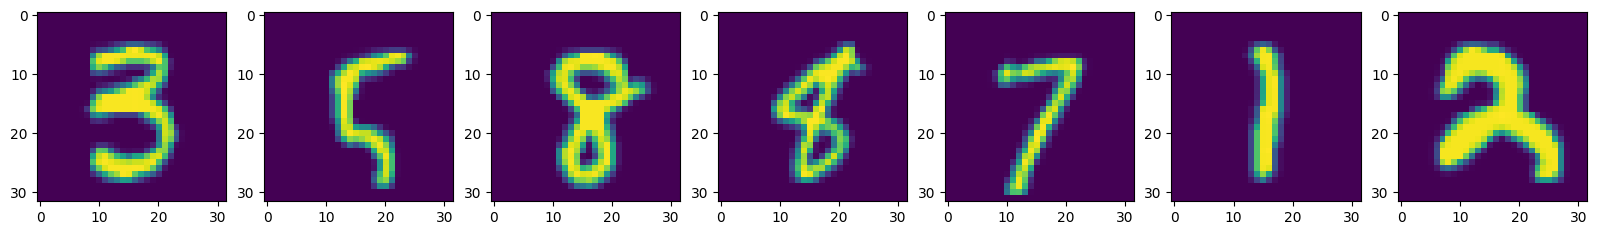

In [41]:
# show examples of images
imgs, _ = next(iter(train_loader))
plt.figure(figsize=(20, 4))
for i in range(7):
    plt.subplot(1, 7, i+1)
    plt.imshow((imgs[i] * std.view(-1, 1, 1) + mean.view(-1, 1, 1)).permute(1, 2, 0))
plt.show()

In [42]:
# compute the dataset statistics

moyenne = torch.tensor([0.0, 0.0, 0.0], dtype=torch.float32)
ecart_type = torch.tensor([0.0, 0.0, 0.0], dtype=torch.float32)
num_samples = 0

for images, _ in tqdm(train_loader):
    moyenne += images.mean(dim=(0, 2, 3)) * images.size(0)  # Multiplier par la taille du batch pour pondérer
    ecart_type += images.std(dim=(0, 2, 3)) * images.size(0)  # Multiplier par la taille du batch pour pondérer
    num_samples += images.size(0)  # Compter le nombre total d'échantillons

    if num_samples > 5000:
        break

moyenne /= num_samples
ecart_type /= num_samples

print(f'Moyenne: {moyenne}, Écart-type: {ecart_type}')

  0%|          | 0/469 [00:00<?, ?it/s]

Moyenne: tensor([-0.0016, -0.0016, -0.0016]), Écart-type: tensor([1.0239, 1.0239, 1.0239])


In [55]:
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1. - betas
alpha_hats = torch.cumprod(alphas, dim=0).view(-1, 1, 1, 1)

def noise_imgs(x0, t):
    noise = torch.randn_like(x0, device=device)    
    noisy_img = torch.sqrt(alpha_hats[t-1]) * x0 + torch.sqrt(1 - alpha_hats[t-1]) * noise   # t-1 car t va de 1 à T et les alpha_hats sont indexés de 0 à T-1
    return noisy_img, noise

def sample(n_imgs, model, labels):
    model.eval()
    with torch.no_grad():
        xt = torch.randn((n_imgs, img_channels, img_size, img_size), device=device)
        for t in range(T, 0, -1):   # la boucle va de T à 1 en décroissant
            z = torch.randn_like(xt) if t>1 else 0
            xt = 1/torch.sqrt(alphas[t-1]) * (xt - (1 - alphas[t-1])/torch.sqrt(1 - alpha_hats[t-1]) * model(xt, t*torch.ones(n_imgs, dtype=torch.int32, device=device), labels)) + torch.sqrt(betas[t-1]) * z
    model.train()
    return xt

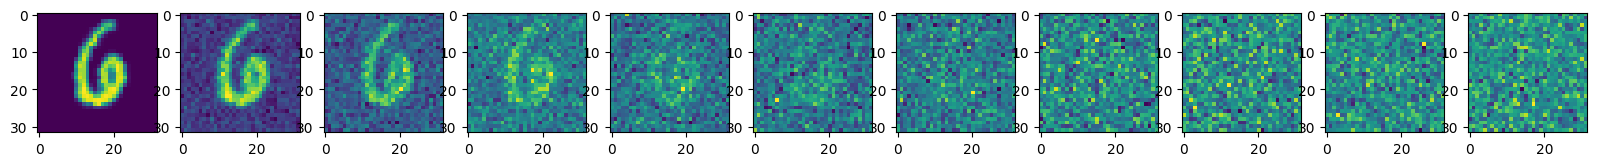

In [44]:
# illustrate the noising processig

train_imgs, _ = next(iter(train_loader))
x0 = train_imgs.to(device)

plt.figure(figsize=(20, 5))
plt.subplot(1, 11, 1)
plt.imshow((x0[0].cpu() * std.view(-1, 1, 1) + mean.view(-1, 1, 1)).permute(1, 2, 0))
for i in range(1, 11):
    plt.subplot(1, 11, i+1)
    t = T//10 * i
    xt, _ = noise_imgs(x0, t)
    plt.imshow((xt[0].cpu() * std.view(-1, 1, 1) + mean.view(-1, 1, 1)).permute(1, 2, 0))
plt.show()

In [45]:
class ConvBlock(nn.Module):

    def __init__(self, in_dim, out_dim, time_dim=256):
        super().__init__()
        self.emb_layer = nn.Linear(time_dim, in_dim)
        self.block = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(1, out_dim),   # équivalent à un LayerNorm
            nn.ReLU(inplace=True),
            nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(1, out_dim),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, t):
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        x = x + emb
        x = self.block(x)
        return x

In [46]:
class UNet(nn.Module):
    
    def __init__(self, time_dim=256):
        super().__init__()
        down_dims = [img_channels, 32, 64, 128, 256]
        up_dims = [512, 256, 128, 64, 32]
        self.t_embedding_table = nn.Embedding(T, time_dim)
        self.down_blocks = nn.ModuleList([ConvBlock(down_dims[i], down_dims[i+1]) for i in range(len(down_dims)-1)])
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle_blocks = ConvBlock(down_dims[-1], up_dims[0])
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(up_dims[i], up_dims[i+1], kernel_size=3, stride=2, padding=1, output_padding=1) for i in range(len(up_dims)-1)])
        self.up_blocks = nn.ModuleList([ConvBlock(up_dims[i], up_dims[i+1]) for i in range(len(up_dims)-1)])
        self.last_conv = nn.Conv2d(up_dims[-1], img_channels, kernel_size=1)
        if n_classes is not None:
            self.label_embedding_table = nn.Embedding(n_classes, time_dim)


    def forward(self, x, t, labels=None):
        t = self.t_embedding_table(t - 1)   # t est entre 1 et 1000 et les index sont entre 0 et 999

        if labels is not None:
            t += self.label_embedding_table(labels)

        down_activations = []
        for down_block in self.down_blocks:
            x = down_block(x, t)
            down_activations.append(x)
            x = self.maxpool(x)

        x = self.middle_blocks(x, t)

        for i in range(len(self.up_blocks)):
            x = self.upconvs[i](x)
            x = torch.cat((x, down_activations[-(i+1)]), dim=1)  # Skip connection
            x = self.up_blocks[i](x, t)

        x = self.last_conv(x)

        return x

In [47]:
model = UNet().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
mse = nn.MSELoss()

loss_list = []

print(f"Num params: {(sum(p.numel() for p in model.parameters())) / 1e6} M")

#d_params = {}
#for p in model.named_parameters():
#    d_params[p[0]] = p[1].numel()
#sorted_d_params = dict(sorted(d_params.items(), key=lambda item: item[1], reverse=True))
#print(sorted_d)

Num params: 9.264706 M


In [48]:
load_parameters = False

if load_parameters:
    print("Loading parameters")
    model.load_state_dict(torch.load("/kaggle/input/artishow-ddpm-1-1-weights-and-loss/latest_weights.pth", weights_only=True))
    with open("/kaggle/input/artishow-ddpm-1-1-weights-and-loss/latest_train_loss.txt", mode='r') as f:
        loss_list = [float(line.strip()) for line in f]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.0247)


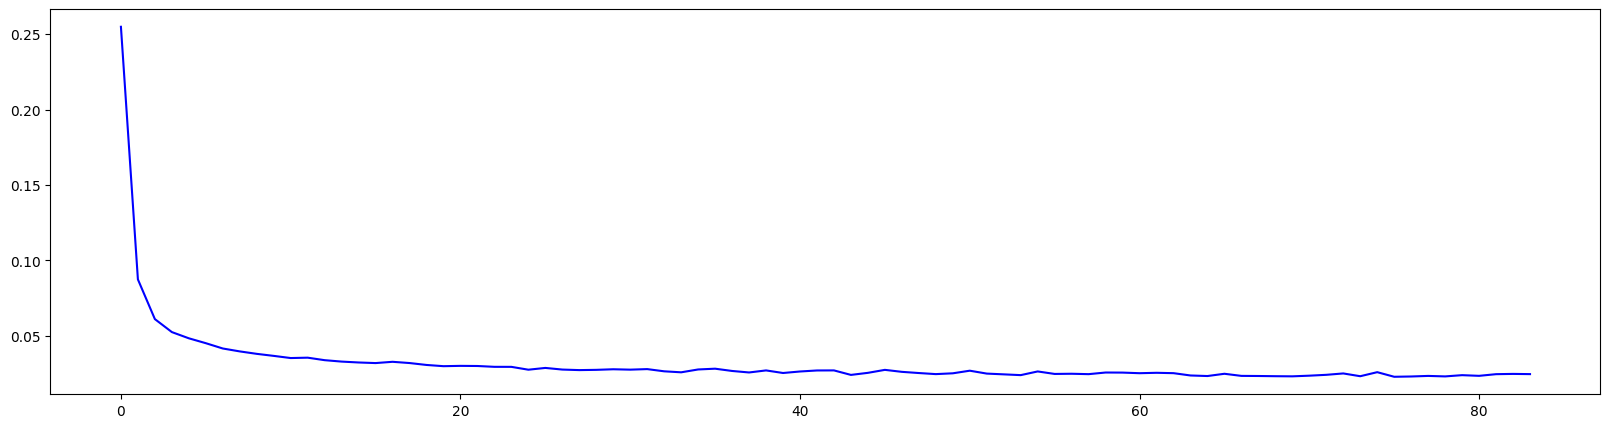

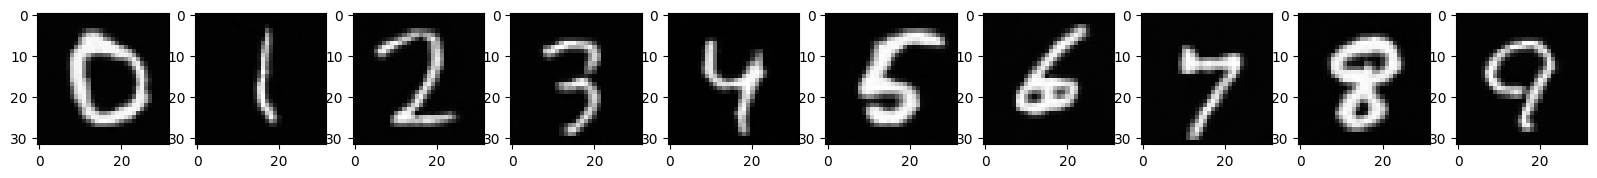

KeyboardInterrupt: 

In [80]:
for epoch in tqdm(range(n_epochs)):
    for i, (train_imgs, labels) in enumerate(tqdm(train_loader)):
        
        x0 = train_imgs.to(device)
        labels = labels.to(device)
        t = torch.randint(1, T+1, size=(x0.shape[0],), device=device)
        xt, noise = noise_imgs(x0, t)

        predicted_noise = model(xt, t, labels)

        loss = mse(predicted_noise, noise)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()


        if i%10 == 0:
            loss_list.append(loss.item())



        if epoch%3 == 0 and (i+1) % 400 == 0:
            s = 20
            loss_list_moyennée = torch.tensor(loss_list[:len(loss_list)//s*s]).view(-1, s).mean(1)
            print(loss_list_moyennée[-1])
            plt.figure(figsize = (20, 5))
            plt.plot(loss_list_moyennée[0:], c="blue")
            plt.show()
            plt.figure(figsize = (20, 5))
            labels = torch.arange(0, 10, device=device)
            sampled_imgs = (sample(10, model, labels))
            for j in range(10):
                plt.subplot(1, 10, j+1)
                plt.imshow((sampled_imgs[j].cpu() * std.view(-1, 1, 1) + mean.view(-1, 1, 1)).permute(1, 2, 0), cmap="gray")
            plt.show()

In [81]:
# sauvegarder les paramètres du model et la loss_list

from IPython.core.display import display, HTML

torch.save(model.state_dict(), f"latest_weights.pth")

with open(f"latest_train_loss.txt", 'w') as f:
    for loss in loss_list:
        f.write(f"{loss}\n")

# pour afficher les liens
from IPython.display import FileLink
display(FileLink(f"./latest_weights.pth"))
display(HTML(f'<a href="{"./latest_train_loss.txt"}" download> latest_train_loss.txt</a>'))

/kaggle/working/latest_weights.pth

In [85]:
def sample_list(n_imgs, model, labels):
    model.eval()
    with torch.no_grad():
        xt = torch.randn((n_imgs, img_channels, img_size, img_size), device=device)
        imgs_list = [xt]
        for t in range(T, 0, -1):   # la boucle va de T à 1 en décroissant
            z = torch.randn_like(xt) if t>1 else 0
            xt = 1/torch.sqrt(alphas[t-1]) * (xt - (1 - alphas[t-1])/torch.sqrt(1 - alpha_hats[t-1]) * model(xt, t*torch.ones(n_imgs, dtype=torch.int32, device=device), labels)) + torch.sqrt(betas[t-1]) * z
            if t % 10 == 0:
                imgs_list.append(xt)
    model.train()
    return imgs_list

labels = torch.tensor([8], device=device)
samples = sample_list(1, model, labels)

  0%|          | 0/101 [00:00<?, ?it/s]

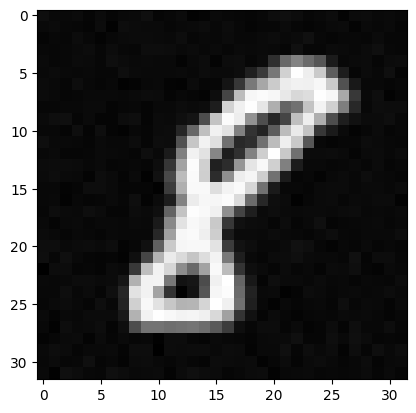

In [86]:
import matplotlib.animation as animation

fig = plt.figure()
ims = []

for i in tqdm(range(len(samples))):
    im = plt.imshow((samples[i][0].cpu() * std.view(-1, 1, 1) + mean.view(-1, 1, 1)).permute(1, 2, 0), animated=True, cmap="gray")
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=1, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()

In [87]:
from IPython.display import Image, display
display(Image(url='./diffusion.gif'))